# I want to train a ML model to solve fizzbuzz.
This is interesting.  Fizzbuzz is defined by a modulus function.  the values are best represted as integer rings, not in cartesian land

In [60]:
from random import randint
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
MAX_INT = 10000000   # up to 100,000,000 int size
MAX_SIZE = 1000  # 1000 samples


mapping={"FizzBuzz":15,"Buzz":5,"Fizz":3,"None":0}
TARGET="Label"
sample_x={"x":[]}
sample_y={"Label":[]}
for i in range(MAX_SIZE):
    r = randint(0,MAX_INT)
    label = "FizzBuzz" if r%15==0 else "Buzz" if r%5==0 else "Fizz" if r%3==0 else "None"
    sample_x["x"].append(r)
    sample_y["Label"].append(label)


df = pd.DataFrame(sample_x|sample_y)
df["Label"]=df["Label"].apply(lambda x: mapping[x])

In [61]:
df.info()
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       1000 non-null   int64
 1   Label   1000 non-null   int64
dtypes: int64(2)
memory usage: 15.8 KB


,x,Label
count,1.000000e+03,1000.000000
mean,5.052685e+06,2.444000
std,2.874061e+06,3.838437
min,6.743000e+03,0.000000
25%,2.593431e+06,0.000000
50%,5.036282e+06,0.000000
75%,7.522368e+06,3.000000
max,9.988007e+06,15.000000


Pearson's correlation of features
Mean-Absolute Pearson Correlation: x        0.506682
Label    0.506682
dtype: float64


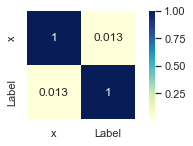

In [62]:
print("Pearson's correlation of features")
def observe_data(df:pd.DataFrame)->None:
    y_size = df.shape[1]
    sns.set(rc = {'figure.figsize':(5,(1*y_size))})
    col_vec = df.corr()
    col_vec = pd.DataFrame(col_vec)
    col_vec=col_vec.apply(lambda x: numpy.abs(x))  # ABS(Correlation) -- remove negatives, rank by absolute val
    col_vec=col_vec.sort_values(TARGET)
    sns.heatmap(col_vec, annot=True, cmap='YlGnBu',square=True)
    print(f"Mean-Absolute Pearson Correlation: {col_vec.mean()}")

observe_data(df)

## Holy cow those Pearson Coefficients are abhorrent.  What did i expect

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

"""
train_test_data={
        "dataset_i":{
            "data":{
                "X_train":  X_train,
                "X_test":   X_test,
                "y_train":  y_train,
                "y_test":   y_test
            },
                "models":{
                    "model_name": accuracy
                }
            }
    }
"""
train_test_data={}
scaler = MinMaxScaler()

print("splitting train and test data")
for i,dataset in enumerate([df]):
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop(TARGET,axis=1), dataset[[TARGET]])
    cols = X_train.columns
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=[cols])
    X_test = pd.DataFrame(X_test, columns=[cols])
    train_test_data.update({
        f"dataset{i}":{
            "data":{
                "X_train":X_train,"X_test":X_test,"y_train":y_train,"y_test":y_test
        },
            "models":{}
        }
    })
print("done")

splitting train and test data
done


In [64]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.exceptions import DataConversionWarning,ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier


def fit_test_model(model, model_name, key, value):
    global train_test_data
    model.fit(value["data"]["X_train"],value["data"]["y_train"])
    y_predicted = model.predict(value["data"]["X_test"])
    test_accuracy=accuracy_score(value["data"]["y_test"], y_predicted.ravel())
    y_trained = model.predict(value["data"]["X_train"])
    train_accuracy = accuracy_score(value["data"]["y_train"], y_trained.ravel())
    train_test_data[key]["models"][model_name]={
        "test_accuracy":test_accuracy,
        "train_accuracy":train_accuracy
    }

# move our results for each model into a single table, rank performance, and display table'
def display_test_results(train_test_data:dict)->None:
    results={"ModelName":[],"Dataset":[],"TestAccuracy":[],"TrainAccuracy":[]}
    for dataset,record in train_test_data.items():
        for modelname in record["models"].keys():
            test_accuracy=record["models"][modelname]["test_accuracy"]*100
            train_accuracy=record["models"][modelname]["train_accuracy"]*100
            results["ModelName"].append(modelname)
            results["Dataset"].append(dataset.replace("dataset",""))
            results["TestAccuracy"].append(test_accuracy)
            results["TrainAccuracy"].append(train_accuracy)
    results=pd.DataFrame(results)
    sorted=results.sort_values(by=['TestAccuracy','TrainAccuracy'],ascending=False)
    print(sorted)

models={
    "default_decision_tree_classifier":DecisionTreeClassifier(),
    "default_multi-layer_perceptron_classifier":MLPClassifier(),
    "default_gradient-boosting_classifier": GradientBoostingClassifier(),
    "default_linear_support_vector_classifier":LinearSVC(),
    "default_knn_classifier":KNeighborsClassifier(),
    "adjusted_random_forest_classifier":RandomForestClassifier(min_samples_split=8,max_depth=8,min_samples_leaf=2),
    "adjusted_multi-layer_perceptron_classifier":MLPClassifier(learning_rate='adaptive',hidden_layer_sizes=(150,)),
    "adjusted_gradient-boosting_classifier": GradientBoostingClassifier(n_estimators=150,min_samples_split=4),
    "adjusted_support_vector_classifier":SVC(degree=2,cache_size=1000,max_iter=200),
    "adjusted_knn_classifier":KNeighborsClassifier(weights='distance')
}

In [65]:
for model_name,model in models.items():
    for key,value in train_test_data.items():
        print(f"training {model_name} using {key}")
        fit_test_model(model, model_name, key, value)
print("done")


training default_decision_tree_classifier using dataset0
training default_multi-layer_perceptron_classifier using dataset0
training default_gradient-boosting_classifier using dataset0
training default_linear_support_vector_classifier using dataset0
training default_knn_classifier using dataset0
training adjusted_random_forest_classifier using dataset0
training adjusted_multi-layer_perceptron_classifier using dataset0
training adjusted_gradient-boosting_classifier using dataset0
training adjusted_support_vector_classifier using dataset0
training adjusted_knn_classifier using dataset0
done


In [66]:
display_test_results(train_test_data)

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import numpy as np
"""
   Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
"""
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt



                                    ModelName Dataset  TestAccuracy  \
1   default_multi-layer_perceptron_classifier       0          58.8   
3    default_linear_support_vector_classifier       0          58.8   
6  adjusted_multi-layer_perceptron_classifier       0          58.8   
5           adjusted_random_forest_classifier       0          55.2   
4                      default_knn_classifier       0          51.2   
2        default_gradient-boosting_classifier       0          50.4   
8          adjusted_support_vector_classifier       0          49.6   
7       adjusted_gradient-boosting_classifier       0          48.4   
9                     adjusted_knn_classifier       0          43.6   
0            default_decision_tree_classifier       0          38.4   

   TrainAccuracy  
1      52.400000  
3      52.400000  
6      52.400000  
5      59.600000  
4      59.733333  
2      71.733333  
8      43.333333  
7      78.533333  
9     100.000000  
0     100.000000  


Processing default_decision_tree_classifier learning curve


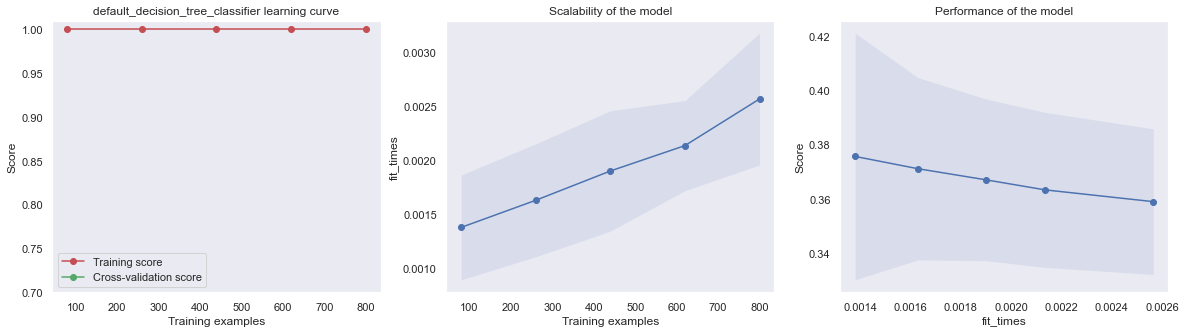

Processing default_multi-layer_perceptron_classifier learning curve


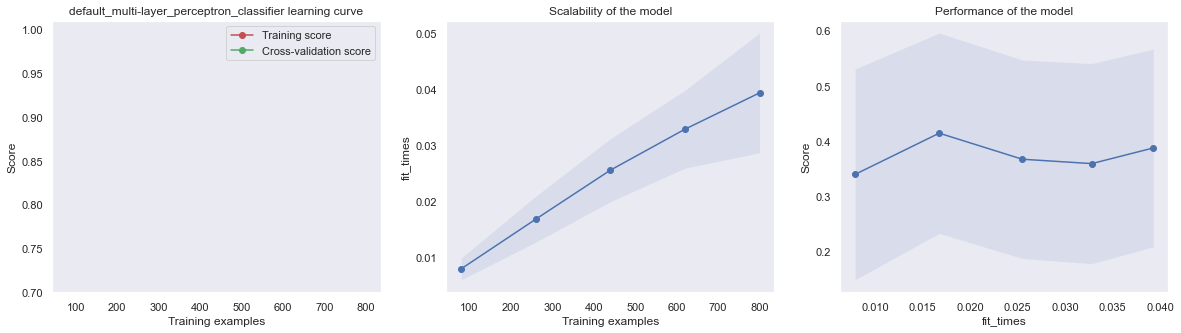

Processing default_gradient-boosting_classifier learning curve


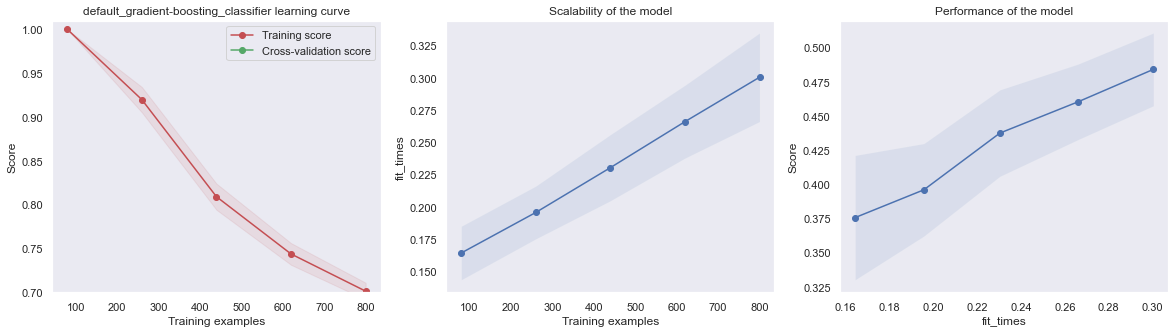

Processing default_linear_support_vector_classifier learning curve


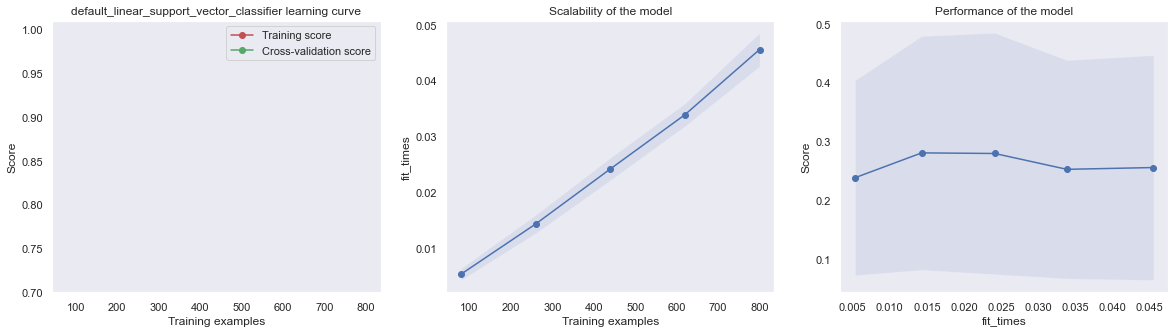

Processing default_knn_classifier learning curve


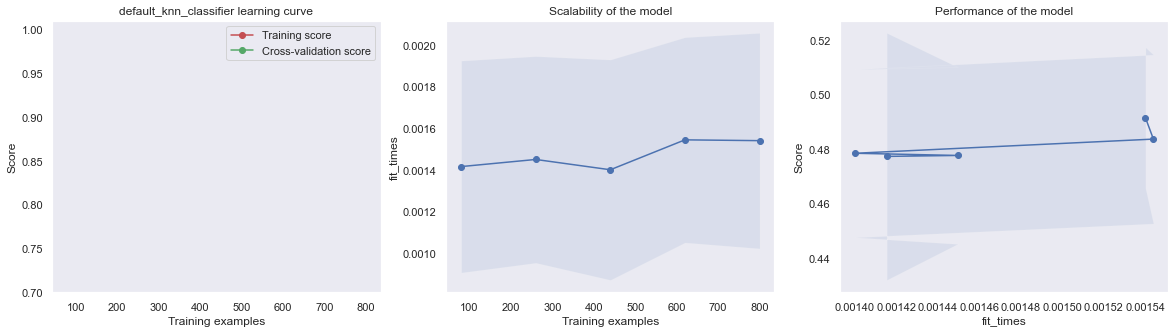

Processing adjusted_random_forest_classifier learning curve


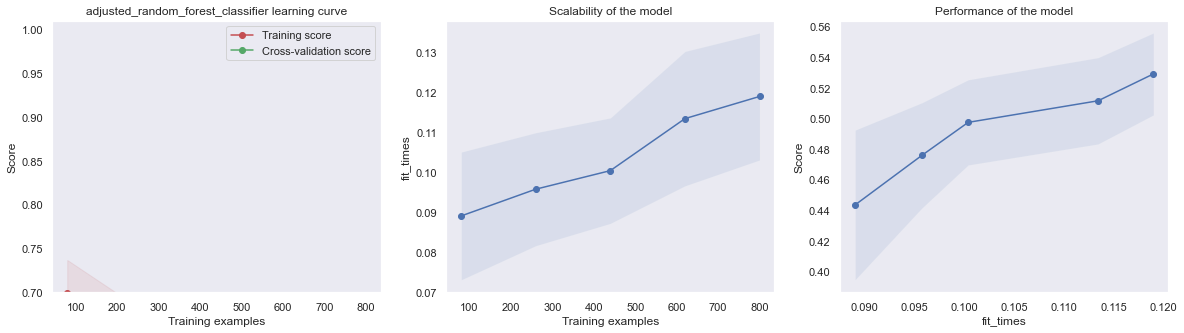

Processing adjusted_multi-layer_perceptron_classifier learning curve


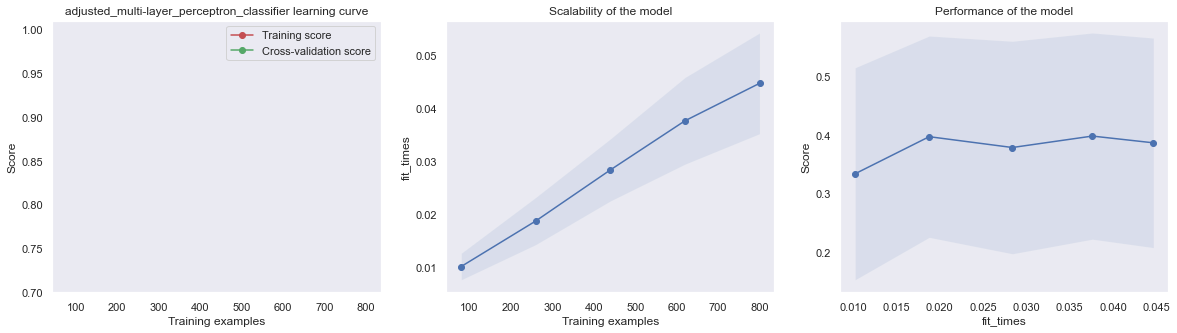

Processing adjusted_gradient-boosting_classifier learning curve


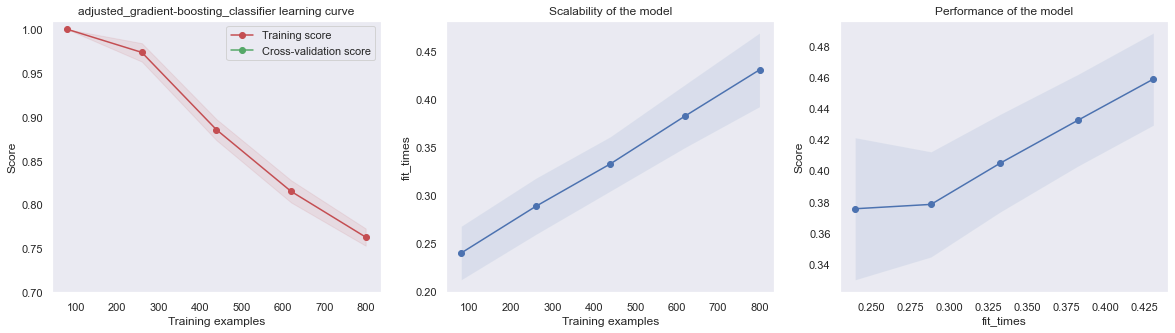

Processing adjusted_support_vector_classifier learning curve


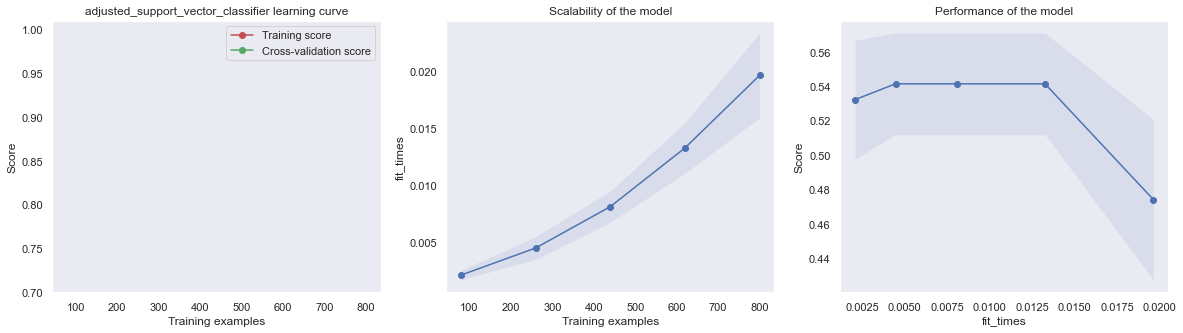

Processing adjusted_knn_classifier learning curve


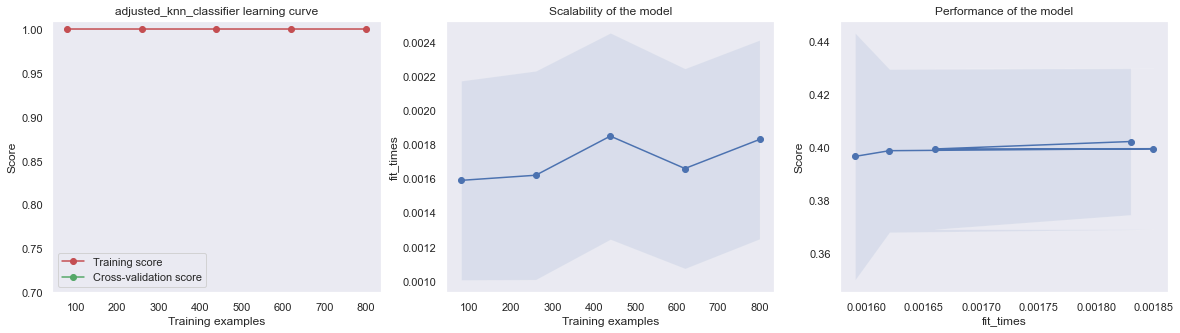

In [68]:
for model_name,model in models.items()docs:
    title = f"{model_name} learning curve"
    print(f"Processing {title}")
    X = df.copy(deep=True)
    y = X.pop(TARGET)
    cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
    plot_learning_curve(model, title, X, y, ylim=(0.7, 1.01),cv=cv, n_jobs=4)
    plt.show()


In [ ]:
print("Done")